In [9]:
!pip install pyspark
!pip install nltk

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace,explode, split
import nltk
from nltk.corpus import stopwords
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, FloatType
import matplotlib.pyplot as plt
from google.colab import files

In [23]:
#Download stopwords for text cleaning
nltk.download('stopwords')

#Initialize Spark Session
spark = SparkSession.builder.appName("TextDataPreprocessing").getOrCreate()

#Upload dataset
uploaded = files.upload()

#Assuming the user uploads a CSV File, retrieve file name
file_name = list(uploaded.keys())[0]

#Load the dataset into a spark dataframe
df = spark.read.csv(file_name, header=True, inferSchema=True)
df.show(truncate=False)

print(df.columns)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving UAQTEresponses.csv to UAQTEresponses.csv
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Responses                                                                                                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
# 1. Remove User Mentions (@username)
df = df.withColumn("Responses", regexp_replace(col("Responses"), r"@\w+", ""))
df.show(truncate=False)

# 2. Remove Hashtags (#hashtag)
df = df.withColumn("Responses", regexp_replace(col("Responses"), r"#\w+", ""))
df.show(truncate=False)

# 3. Remove URLs, Special Characters, and Emojis
df = df.withColumn("Responses", regexp_replace(col("Responses"), r"http\S+|[^a-zA-Z\s]", ""))
df.show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Responses                                                                                                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
#4. Convert to Lowercase
df = df.withColumn("Responses",lower(col("Responses")))
df.show(truncate=False)

#5. Tokenize Words (Split Into List of Words)
# Change the column name to 'Words' to avoid issues
df = df.withColumn("Words", split(col("responses"), " "))
df.show(truncate=False)

#6.Remove Stopwords
#Get list of stopwords
stop_words = set(stopwords.words("english"))
additional_stopwords = {"uaqte", "UAQTE"} #Custom stopwords
stop_words.update(additional_stopwords)

#Define UDF
def remove_stopwords(words):
  return [word for word in words if word not in stop_words and word !=""]

remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))

# Use the 'Words' column for stop word removal
df = df.withColumn("Filtered_Words",remove_stopwords_udf(col("Words")))

#Show cleaned dataset
df.select("responses", "Filtered_Words").show(truncate=False)

#Exploded words into seperate rows
df_exploded = df.select(explode(col("Filtered_Words")).alias("Word"))

#Count occurences of each word
word_counts = df_exploded.groupBy("Word").count().orderBy(col("count").desc())

#Show most common words
word_counts.show()


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------

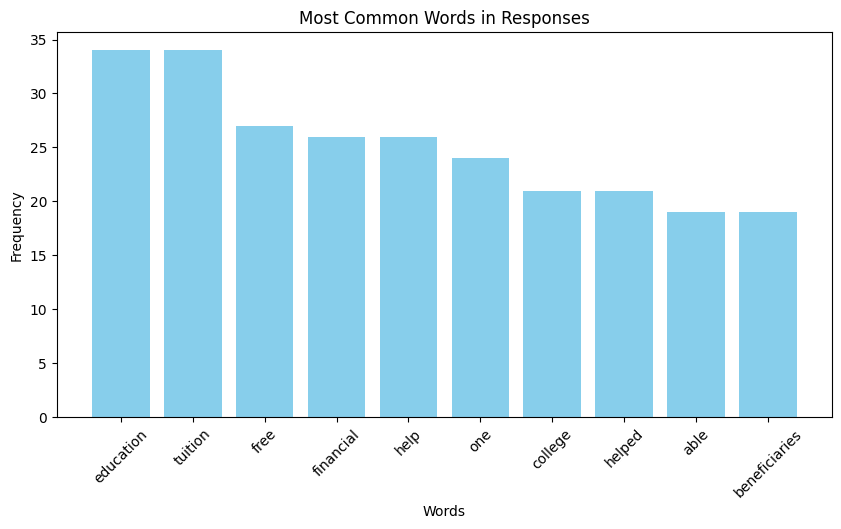

In [28]:
#Convert to Pandas

word_counts_pd = word_counts.limit(10).toPandas()

#Plot bar chart

plt.figure(figsize=(10, 5))
plt.bar(word_counts_pd["Word"], word_counts_pd["count"], color="skyblue")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Responses")
plt.xticks(rotation=45)
plt.show()

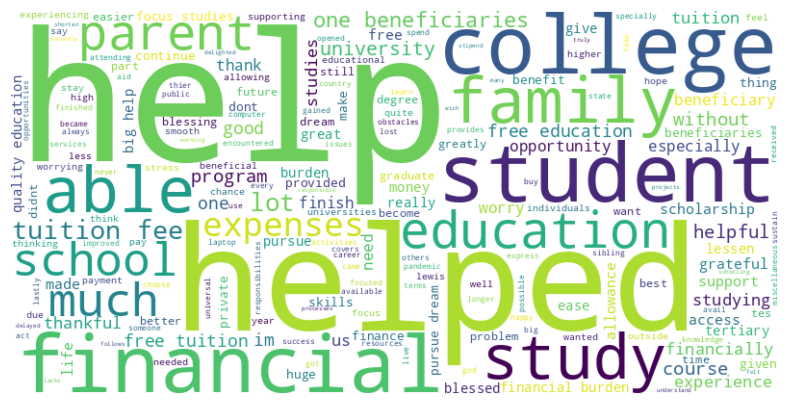

In [29]:
from wordcloud import WordCloud

#Generate a string of all word
text = " ".join(df_exploded.select("Word").rdd.flatMap(lambda x: x).collect())

#Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

#Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

spark.stop()